In [ ]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import joblib
import warnings
warnings.filterwarnings('ignore')

In [ ]:
%%time
df = pd.read_csv("/content/drive/MyDrive/Major Project/dataset_processed.csv")

CPU times: user 19.4 s, sys: 2.01 s, total: 21.4 s
Wall time: 27 s


In [ ]:
X = df.drop('Target', axis = 1)
y = df.Target

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


X_sample, X_test, y_sample, y_test = train_test_split(X,
                                      y,
                                      train_size = 0.02,
                                      stratify = y,
                                      random_state = 42)

# Create the Random Forest model
rf_model = RandomForestClassifier(n_estimators = 100,
                                  class_weight = 'balanced',
                                  random_state = 42)

In [ ]:
len(X_sample)

80029

In [ ]:
# Wrapping the fitting process with tqdm to track progress
with tqdm(total=100, desc="Training Random Forest") as pbar:
    for _ in range(100):  # We simulate the "progress" bar to represent the fit process
        rf_model.fit(X_sample, y_sample)
        pbar.update(1)  # Update progress bar with each fit iteration (simulated here)

# After training, extract feature importances
feature_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values(by='importance', ascending=False)

# Display top 10 important features
print("Top 10 important Features:")
print(feature_importance_df.head(10))

Training Random Forest: 100%|██████████| 100/100 [2:07:09<00:00, 76.29s/it]

Top 10 important Features:
      feature  importance
15  Manganese    0.119341
1          pH    0.104932
4    Chloride    0.088286
8   Turbidity    0.086076
10     Copper    0.074915
11       Odor    0.070871
9    Fluoride    0.053588
3     Nitrate    0.049889
14   Chlorine    0.049729
2        Iron    0.048581


In [ ]:
feature_importance_df

,feature,importance
15,Manganese,0.119341
1,pH,0.104932
4,Chloride,0.088286
8,Turbidity,0.086076
10,Copper,0.074915
11,Odor,0.070871
9,Fluoride,0.053588
3,Nitrate,0.049889
14,Chlorine,0.049729
2,Iron,0.048581


In [ ]:
feature_importance_df.to_csv("drive/MyDrive/Major Project/RF_features.csv")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [ ]:
def sample_data(data, target, sample_fraction=0.1, random_state=42):
    """
    Randomly sample a fraction of the dataset while preserving class distribution.

    Parameters:
    - data: DataFrame, the full dataset.
    - target: str, the target column name.
    - sample_fraction: float, the fraction of data to sample (default: 0.1, or 10%).
    - random_state: int, random seed for reproducibility.

    Returns:
    - sampled_data: DataFrame, sampled data with preserved class distribution.
    """
    # Ensure class distribution is preserved using stratified sampling
    sampled_data = data.groupby(target, group_keys=False).apply(
        lambda x: x.sample(frac=sample_fraction, random_state=random_state)
    )
    return sampled_data

In [ ]:
def select_features(data, important_features, num_features):
    """
    Select top `num_features` from the already sorted list of important features.
    """
    selected_features = important_features[:num_features]
    return data[selected_features]

In [ ]:
def split_data(X, y, test_size=0.1, random_state=42):
    """
    Split the data into training and testing sets.
    """
    return train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

In [ ]:
def balance_data(X_train, y_train):
    """
    Apply SMOTE to balance the training data.
    """
    sm = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)
    return X_train_resampled, y_train_resampled

In [ ]:
def train_model(X_train, y_train):
    """
    Train the RandomForest model with tqdm progress bar.
    """
    model = RandomForestClassifier(random_state=42)

    # Wrapping the model fitting inside tqdm to show progress
    with tqdm(total=len(X_train), desc="Training Model") as pbar:
        model.fit(X_train, y_train)
        pbar.update(len(X_train))  # Update progress bar once training is complete

    return model

In [ ]:
def evaluate_model(model, X_test, y_test):
    """
    Evaluate the model and return classification report and confusion matrix.
    """
    y_pred = model.predict(X_test)
    return classification_report(y_test, y_pred), confusion_matrix(y_test, y_pred)

In [ ]:
def train_and_evaluate(data, target, important_features, num_features=10, sample_fraction=0.1):
    """
    Train and evaluate the Random Forest model on selected features with optional data sampling.
    """
    # Step 0: Sample the data
    data_sampled = sample_data(data, target, sample_fraction=sample_fraction)

    # Step 1: Select features
    X = select_features(data_sampled, important_features, num_features)
    y = data_sampled[target]

    # Step 2: Split data into training and testing sets
    X_train, X_test, y_train, y_test = split_data(X, y)

    # Step 3: Balance training data using SMOTE
    X_train_resampled, y_train_resampled = balance_data(X_train, y_train)

    # Step 4: Train the model
    model = train_model(X_train_resampled, y_train_resampled)

    # Step 5: Evaluate the model
    class_report, conf_matrix = evaluate_model(model, X_test, y_test)

    # Print the evaluation results
    print("Classification Report:\n", class_report)

    plt.figure(figsize = (6,4))
    sns.heatmap(conf_matrix, annot = True, fmt = "d", cmap = "Blues", xticklabels = model.classes_, yticklabels = model.classes_)
    plt.title("Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('True labels')
    plt.show()
    return class_report, conf_matrix

In [ ]:
data = pd.read_csv("drive/MyDrive/Major Project/dataset_processed.csv")
target = 'Target'
num_features = 5

In [ ]:
features = pd.read_csv("drive/MyDrive/Major Project/RF_features.csv")
important_features = features['feature'].to_list()
important_features = [i for i in important_features if i != 'Index' ]

Training Model: 100%|██████████| 418948/418948 [05:54<00:00, 1181.27it/s]


Classification Report:
               precision    recall  f1-score   support

         0.0       0.92      0.86      0.89     69825
         1.0       0.72      0.84      0.78     30212

    accuracy                           0.85    100037
   macro avg       0.82      0.85      0.83    100037
weighted avg       0.86      0.85      0.86    100037



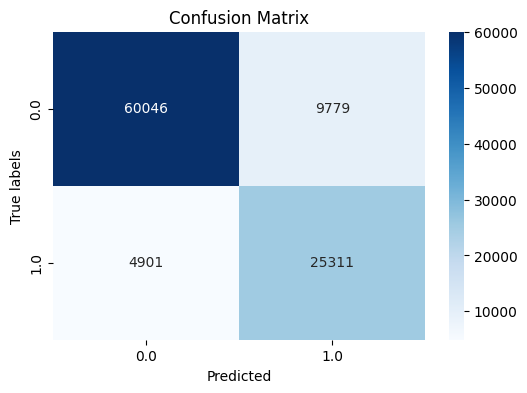

('              precision    recall  f1-score   support\n\n         0.0       0.92      0.86      0.89     69825\n         1.0       0.72      0.84      0.78     30212\n\n    accuracy                           0.85    100037\n   macro avg       0.82      0.85      0.83    100037\nweighted avg       0.86      0.85      0.86    100037\n',
 array([[60046,  9779],
        [ 4901, 25311]]))

In [ ]:
train_and_evaluate(data,
                   target,
                   important_features,
                   num_features = num_features)

Training Model: 100%|██████████| 418948/418948 [05:59<00:00, 1164.89it/s]


Classification Report:
               precision    recall  f1-score   support

         0.0       0.95      0.85      0.90     69825
         1.0       0.72      0.91      0.81     30212

    accuracy                           0.87    100037
   macro avg       0.84      0.88      0.85    100037
weighted avg       0.89      0.87      0.87    100037



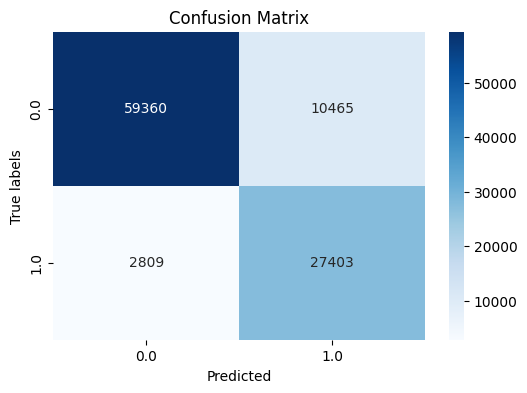

('              precision    recall  f1-score   support\n\n         0.0       0.95      0.85      0.90     69825\n         1.0       0.72      0.91      0.81     30212\n\n    accuracy                           0.87    100037\n   macro avg       0.84      0.88      0.85    100037\nweighted avg       0.89      0.87      0.87    100037\n',
 array([[59360, 10465],
        [ 2809, 27403]]))

In [ ]:
num_features_1 = 7

train_and_evaluate(data,
                   target,
                   important_features,
                   num_features = num_features_1)

Training Model: 100%|██████████| 418948/418948 [09:02<00:00, 771.93it/s]


Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.84      0.91     69825
         1.0       0.72      0.96      0.83     30212

    accuracy                           0.88    100037
   macro avg       0.85      0.90      0.87    100037
weighted avg       0.90      0.88      0.88    100037



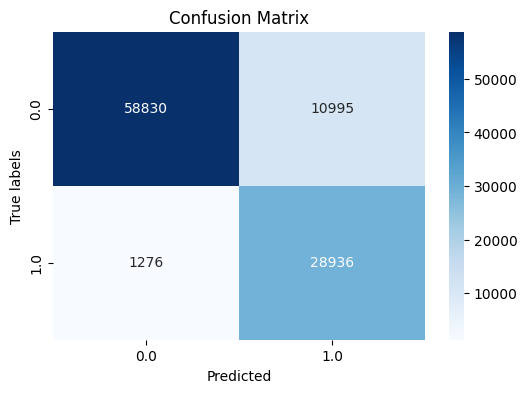

('              precision    recall  f1-score   support\n\n         0.0       0.98      0.84      0.91     69825\n         1.0       0.72      0.96      0.83     30212\n\n    accuracy                           0.88    100037\n   macro avg       0.85      0.90      0.87    100037\nweighted avg       0.90      0.88      0.88    100037\n',
 array([[58830, 10995],
        [ 1276, 28936]]))

In [ ]:
num_features_2 = 10

train_and_evaluate(data,
                   target,
                   important_features,
                   num_features = num_features_2)